In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Notebook Color Scheme:



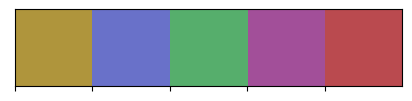

In [68]:
class CustomOrdinalEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.cat_to_int = {}
        self.int_to_cat = {}
        for i, cat in enumerate(self.categories):
            self.cat_to_int[cat] = i
            self.int_to_cat[i] = cat

    def transform(self, data):
        return np.array([self.cat_to_int[cat] if cat in self.cat_to_int else np.nan for cat in data])

    def inverse_transform(self, data):
        return np.array([self.int_to_cat[int(cat)] for cat in data])

def encode_ordinal_columns(df, ordinal_columns, n_classes):
    encoders = {}
    encoded_df = df.copy()
    for col in ordinal_columns:
        unique_values = sorted(df[col].dropna().unique())
        categories = unique_values + [f"extra_class_{i}" for i in range(n_classes - len(unique_values))]
        encoder = CustomOrdinalEncoder(categories)
        encoded_df[col] = encoder.transform(df[col])
        encoders[col] = encoder
    return encoded_df, encoders

def impute_missing_ordinal_records(df, ordinal_columns, n_neighbors=3, n_classes=5):
    encoded_df, encoders = encode_ordinal_columns(df, ordinal_columns, n_classes)
    
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='uniform')
    imputed_array = imputer.fit_transform(encoded_df)

    imputed_df = pd.DataFrame(imputed_array, columns=df.columns)
    imputed_df[ordinal_columns] = np.round(imputed_df[ordinal_columns])

    for col in ordinal_columns:
        imputed_df[col] = encoders[col].inverse_transform(imputed_df[col])

    return imputed_df

# Custom colors
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'

# The custom colors chosen here were generated by 'I want hue' app. 
# The were chosen for color-blindness.
our_colors = ["#af953c", "#6971c9", "#56ae6c",
             "#a24f99", "#ba4a4f"]

# Optionally, create a color map, particularly for future use.
CMAP1 = ListedColormap(our_colors)

# Display our own color scheme, as a reference.
print(clr.S+'Notebook Color Scheme:\n'+clr.E)
sns.palplot(sns.color_palette(our_colors))
plt.show()

In [19]:
survey_df = pd.read_csv("Surveydata_train.csv")
survey_df_test = pd.read_csv("Surveydata_test.csv")
display(survey_df.head())
display(survey_df_test.head())

,ID,Overall_Experience,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,Onlinebooking_Ease,Onboard_service,Leg_room,Baggage_handling,Checkin_service,Cleanliness,Online_boarding
0,2100001,0,need improvement,Green Car,excellent,excellent,very convinient,good,need improvement,acceptable,need improvement,need improvement,acceptable,need improvement,good,need improvement,poor
1,2100002,0,poor,Ordinary,excellent,poor,need improvement,good,poor,good,good,excellent,need improvement,poor,need improvement,good,good
2,2100003,1,need improvement,Green Car,need improvement,need improvement,need improvement,need improvement,good,excellent,excellent,excellent,excellent,excellent,good,excellent,excellent
3,2100004,0,acceptable,Ordinary,need improvement,NaN,need improvement,acceptable,need improvement,acceptable,acceptable,acceptable,acceptable,acceptable,good,acceptable,acceptable
4,2100005,1,acceptable,Ordinary,acceptable,acceptable,manageable,need improvement,good,excellent,good,good,good,good,good,good,good


,ID,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,Onlinebooking_Ease,Onboard_service,Leg_room,Baggage_handling,Checkin_service,Cleanliness,Online_boarding
0,3100001,acceptable,Green Car,acceptable,acceptable,manageable,need improvement,excellent,good,excellent,excellent,excellent,excellent,good,excellent,poor
1,3100002,extremely poor,Ordinary,good,poor,manageable,acceptable,poor,acceptable,acceptable,excellent,acceptable,good,acceptable,excellent,acceptable
2,3100003,excellent,Ordinary,excellent,excellent,very convinient,excellent,excellent,excellent,need improvement,need improvement,need improvement,need improvement,good,need improvement,excellent
3,3100004,acceptable,Green Car,excellent,acceptable,very convinient,poor,acceptable,excellent,poor,acceptable,need improvement,excellent,excellent,excellent,poor
4,3100005,excellent,Ordinary,extremely poor,excellent,need improvement,excellent,excellent,excellent,excellent,NaN,acceptable,excellent,excellent,excellent,excellent


In [20]:
display(survey_df.info())
display(survey_df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_time_convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_location        94349 non-null  object
 7   Onboardwifi_service      94349 non-null  object
 8   Onboard_entertainment    94361 non-null  object
 9   Online_support           94288 non-null  object
 10  Onlinebooking_Ease       94306 non-null  object
 11  Onboard_service          86778 non-null  object
 12  Leg_room                 94289 non-null  object
 13  Baggage_handling         94237 non-null  object
 14  Checkin_service          94302 non-nul

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       35602 non-null  int64 
 1   Seat_comfort             35580 non-null  object
 2   Seat_Class               35602 non-null  object
 3   Arrival_time_convenient  32277 non-null  object
 4   Catering                 32245 non-null  object
 5   Platform_location        35590 non-null  object
 6   Onboardwifi_service      35590 non-null  object
 7   Onboard_entertainment    35594 non-null  object
 8   Online_support           35576 non-null  object
 9   Onlinebooking_Ease       35584 non-null  object
 10  Onboard_service          32730 non-null  object
 11  Leg_room                 35577 non-null  object
 12  Baggage_handling         35562 non-null  object
 13  Checkin_service          35580 non-null  object
 14  Cleanliness              35600 non-nul

None

In [21]:
display(survey_df.iloc[:,2:17].describe(include = 'all'))
display(survey_df_test.iloc[:,1:16].describe(include = 'all'))

,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,Onlinebooking_Ease,Onboard_service,Leg_room,Baggage_handling,Checkin_service,Cleanliness,Online_boarding
count,94318,94379,85449,85638,94349,94349,94361,94288,94306,86778,94289,94237,94302,94373,94373
unique,6,2,6,6,6,6,6,6,6,6,6,5,6,6,6
top,acceptable,Green Car,good,acceptable,manageable,good,good,good,good,good,good,good,good,good,good
freq,21158,47435,19574,18468,24173,22835,30446,30016,28909,27265,28870,34944,26502,35427,25533


,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,Onlinebooking_Ease,Onboard_service,Leg_room,Baggage_handling,Checkin_service,Cleanliness,Online_boarding
count,35580,35602,32277,32245,35590,35590,35594,35576,35584,32730,35577,35562,35580,35600,35600
unique,6,2,6,6,5,6,6,5,6,5,6,5,5,5,6
top,acceptable,Ordinary,good,acceptable,manageable,good,good,good,good,good,good,good,good,good,good
freq,8003,17860,7361,7133,9364,8743,11436,11487,11025,10222,10842,13291,9982,13421,9680


In [22]:
display(survey_df.isna().sum())
display(survey_df_test.isna().sum())

ID                            0
Overall_Experience            0
Seat_comfort                 61
Seat_Class                    0
Arrival_time_convenient    8930
Catering                   8741
Platform_location            30
Onboardwifi_service          30
Onboard_entertainment        18
Online_support               91
Onlinebooking_Ease           73
Onboard_service            7601
Leg_room                     90
Baggage_handling            142
Checkin_service              77
Cleanliness                   6
Online_boarding               6
dtype: int64

ID                            0
Seat_comfort                 22
Seat_Class                    0
Arrival_time_convenient    3325
Catering                   3357
Platform_location            12
Onboardwifi_service          12
Onboard_entertainment         8
Online_support               26
Onlinebooking_Ease           18
Onboard_service            2872
Leg_room                     25
Baggage_handling             40
Checkin_service              22
Cleanliness                   2
Online_boarding               2
dtype: int64

In [23]:
travel_df = pd.read_csv("Traveldata_train.csv")
display(travel_df.head())
travel_df_test = pd.read_csv("Traveldata_test.csv")
display(travel_df_test.head())

,ID,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
0,2100001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,2100002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,2100003,Female,Loyal Customer,43.0,Business travel,Business,1061,77.0,119.0
3,2100004,Female,Loyal Customer,44.0,Business travel,Business,780,13.0,18.0
4,2100005,Female,Loyal Customer,50.0,Business travel,Business,1981,0.0,0.0


,ID,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
0,3100001,Female,NaN,36.0,Business travel,Business,532,0.0,0.0
1,3100002,Female,disloyal Customer,21.0,Business travel,Business,1425,9.0,28.0
2,3100003,Male,Loyal Customer,60.0,Business travel,Business,2832,0.0,0.0
3,3100004,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0
4,3100005,Male,disloyal Customer,18.0,Business travel,Business,1610,17.0,0.0


In [24]:
display(travel_df.info())
display(travel_df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      94379 non-null  int64  
 1   Gender                  94302 non-null  object 
 2   CustomerType            85428 non-null  object 
 3   Age                     94346 non-null  float64
 4   TypeTravel              85153 non-null  object 
 5   Travel_Class            94379 non-null  object 
 6   Travel_Distance         94379 non-null  int64  
 7   DepartureDelay_in_Mins  94322 non-null  float64
 8   ArrivalDelay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      35602 non-null  int64  
 1   Gender                  35572 non-null  object 
 2   CustomerType            32219 non-null  object 
 3   Age                     35591 non-null  float64
 4   TypeTravel              32154 non-null  object 
 5   Travel_Class            35602 non-null  object 
 6   Travel_Distance         35602 non-null  int64  
 7   DepartureDelay_in_Mins  35573 non-null  float64
 8   ArrivalDelay_in_Mins    35479 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.4+ MB


None

In [25]:
display(travel_df.iloc[:,1:9].describe(include ='all'))
display(travel_df_test.iloc[:,1:9].describe(include ='all'))

,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
count,94302,85428,94346.000000,85153,94379,94379.000000,94322.000000,94022.000000
unique,2,2,NaN,2,2,NaN,NaN,NaN
top,Female,Loyal Customer,NaN,Business travel,Eco,NaN,NaN,NaN
freq,47815,69823,NaN,58617,49342,NaN,NaN,NaN
mean,NaN,NaN,39.419647,NaN,NaN,1978.888185,14.647092,15.005222
std,NaN,NaN,15.116632,NaN,NaN,1027.961019,38.138781,38.439409
min,NaN,NaN,7.000000,NaN,NaN,50.000000,0.000000,0.000000
25%,NaN,NaN,27.000000,NaN,NaN,1359.000000,0.000000,0.000000
50%,NaN,NaN,40.000000,NaN,NaN,1923.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,NaN,NaN,2538.000000,12.000000,13.000000


,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
count,35572,32219,35591.000000,32154,35602,35602.000000,35573.000000,35479.000000
unique,2,2,NaN,2,2,NaN,NaN,NaN
top,Female,Loyal Customer,NaN,Business travel,Eco,NaN,NaN,NaN
freq,18069,26349,NaN,22313,18473,NaN,NaN,NaN
mean,NaN,NaN,39.446995,NaN,NaN,1987.151761,14.880696,15.308802
std,NaN,NaN,15.137554,NaN,NaN,1024.308863,37.895453,38.531293
min,NaN,NaN,7.000000,NaN,NaN,50.000000,0.000000,0.000000
25%,NaN,NaN,27.000000,NaN,NaN,1360.000000,0.000000,0.000000
50%,NaN,NaN,40.000000,NaN,NaN,1929.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,NaN,NaN,2559.000000,13.000000,13.000000


In [26]:
display(travel_df.isna().sum())
display(travel_df_test.isna().sum())

ID                           0
Gender                      77
CustomerType              8951
Age                         33
TypeTravel                9226
Travel_Class                 0
Travel_Distance              0
DepartureDelay_in_Mins      57
ArrivalDelay_in_Mins       357
dtype: int64

ID                           0
Gender                      30
CustomerType              3383
Age                         11
TypeTravel                3448
Travel_Class                 0
Travel_Distance              0
DepartureDelay_in_Mins      29
ArrivalDelay_in_Mins       123
dtype: int64

In [27]:
# Merge the two datasets

merged_df = pd.merge(survey_df, travel_df, on= 'ID')
display(merged_df.head())

merged_df_test = pd.merge(survey_df_test, travel_df_test, on= 'ID')
display(merged_df_test.head())

,ID,Overall_Experience,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
0,2100001,0,need improvement,Green Car,excellent,excellent,very convinient,good,need improvement,acceptable,...,need improvement,poor,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,2100002,0,poor,Ordinary,excellent,poor,need improvement,good,poor,good,...,good,good,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,2100003,1,need improvement,Green Car,need improvement,need improvement,need improvement,need improvement,good,excellent,...,excellent,excellent,Female,Loyal Customer,43.0,Business travel,Business,1061,77.0,119.0
3,2100004,0,acceptable,Ordinary,need improvement,NaN,need improvement,acceptable,need improvement,acceptable,...,acceptable,acceptable,Female,Loyal Customer,44.0,Business travel,Business,780,13.0,18.0
4,2100005,1,acceptable,Ordinary,acceptable,acceptable,manageable,need improvement,good,excellent,...,good,good,Female,Loyal Customer,50.0,Business travel,Business,1981,0.0,0.0


,ID,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,Onlinebooking_Ease,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
0,3100001,acceptable,Green Car,acceptable,acceptable,manageable,need improvement,excellent,good,excellent,...,excellent,poor,Female,NaN,36.0,Business travel,Business,532,0.0,0.0
1,3100002,extremely poor,Ordinary,good,poor,manageable,acceptable,poor,acceptable,acceptable,...,excellent,acceptable,Female,disloyal Customer,21.0,Business travel,Business,1425,9.0,28.0
2,3100003,excellent,Ordinary,excellent,excellent,very convinient,excellent,excellent,excellent,need improvement,...,need improvement,excellent,Male,Loyal Customer,60.0,Business travel,Business,2832,0.0,0.0
3,3100004,acceptable,Green Car,excellent,acceptable,very convinient,poor,acceptable,excellent,poor,...,excellent,poor,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0
4,3100005,excellent,Ordinary,extremely poor,excellent,need improvement,excellent,excellent,excellent,excellent,...,excellent,excellent,Male,disloyal Customer,18.0,Business travel,Business,1610,17.0,0.0


In [84]:
# Shape of the original and merged data
display(travel_df.shape)
display(survey_df.shape)
display(merged_df.shape)

(94379, 9)

(94379, 17)

(94379, 25)

## 

## Checking for distinct values of the data.

Looking at the heatmap, we see the correlation among the various features. Grouping together the values of these correlated features gives as an indication of how we may imput the missing values.

A better idea would probably be to plot these...


In [77]:
# Overall_Experience and Onboard_entertainment
merged_df.groupby(['Overall_Experience', 'Onboard_entertainment'])['Overall_Experience', 'Onboard_entertainment'].value_counts().reset_index()

/var/folders/fn/f9_8r_cj7cb6ffsgnzdj0yw40000gn/T/ipykernel_46195/1698342611.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df.groupby(['Overall_Experience', 'Onboard_entertainment'])['Overall_Experience', 'Onboard_entertainment'].value_counts().reset_index()


,Overall_Experience,Onboard_entertainment,0
0,0,acceptable,14075
1,0,excellent,1022
2,0,extremely poor,739
3,0,good,8548
4,0,need improvement,11589
5,0,poor,6805
6,1,acceptable,3485
7,1,excellent,20622
8,1,extremely poor,1405
9,1,good,21898


In [28]:
display(merged_df.info())
display(merged_df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Overall_Experience       94379 non-null  int64  
 2   Seat_comfort             94318 non-null  object 
 3   Seat_Class               94379 non-null  object 
 4   Arrival_time_convenient  85449 non-null  object 
 5   Catering                 85638 non-null  object 
 6   Platform_location        94349 non-null  object 
 7   Onboardwifi_service      94349 non-null  object 
 8   Onboard_entertainment    94361 non-null  object 
 9   Online_support           94288 non-null  object 
 10  Onlinebooking_Ease       94306 non-null  object 
 11  Onboard_service          86778 non-null  object 
 12  Leg_room                 94289 non-null  object 
 13  Baggage_handling         94237 non-null  object 
 14  Checkin_service       

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Seat_comfort             35580 non-null  object 
 2   Seat_Class               35602 non-null  object 
 3   Arrival_time_convenient  32277 non-null  object 
 4   Catering                 32245 non-null  object 
 5   Platform_location        35590 non-null  object 
 6   Onboardwifi_service      35590 non-null  object 
 7   Onboard_entertainment    35594 non-null  object 
 8   Online_support           35576 non-null  object 
 9   Onlinebooking_Ease       35584 non-null  object 
 10  Onboard_service          32730 non-null  object 
 11  Leg_room                 35577 non-null  object 
 12  Baggage_handling         35562 non-null  object 
 13  Checkin_service          35580 non-null  object 
 14  Cleanliness           

None

In [29]:
display(merged_df.isna().sum())
display(merged_df_test.isna().sum())

ID                            0
Overall_Experience            0
Seat_comfort                 61
Seat_Class                    0
Arrival_time_convenient    8930
Catering                   8741
Platform_location            30
Onboardwifi_service          30
Onboard_entertainment        18
Online_support               91
Onlinebooking_Ease           73
Onboard_service            7601
Leg_room                     90
Baggage_handling            142
Checkin_service              77
Cleanliness                   6
Online_boarding               6
Gender                       77
CustomerType               8951
Age                          33
TypeTravel                 9226
Travel_Class                  0
Travel_Distance               0
DepartureDelay_in_Mins       57
ArrivalDelay_in_Mins        357
dtype: int64

ID                            0
Seat_comfort                 22
Seat_Class                    0
Arrival_time_convenient    3325
Catering                   3357
Platform_location            12
Onboardwifi_service          12
Onboard_entertainment         8
Online_support               26
Onlinebooking_Ease           18
Onboard_service            2872
Leg_room                     25
Baggage_handling             40
Checkin_service              22
Cleanliness                   2
Online_boarding               2
Gender                       30
CustomerType               3383
Age                          11
TypeTravel                 3448
Travel_Class                  0
Travel_Distance               0
DepartureDelay_in_Mins       29
ArrivalDelay_in_Mins        123
dtype: int64

**Conclusion:** Categorical columns CustomerType, TypeTravel, Arrival_time_convenient, Catering & Onboard_service will need ML-based imputation.

In [30]:
transformed_df = (
    merged_df
    .replace(['excellent', 'good', 'acceptable', 'need improvement', 'poor', 'extremely poor'], [5, 4, 3, 2, 1, 0])
    .replace(['very convinient', 'Convinient', 'manageable', 'need improvement', 'Inconvinient', 'very inconvinient'], [5, 4, 3, 2, 1, 0])
    .replace(['Ordinary', 'Green Car'], [0, 1])
    .replace(['need improvement', 'poor', 'excellent', 'acceptable', 'good'], [2, 1, 5, 3, 4])
    .replace(['Male', 'Female'], [0, 1])
    .replace(['disloyal Customer', 'Loyal Customer'], [0, 1])
    .replace(['Personal Travel', 'Business travel'], [0, 1])
    .replace(['Eco', 'Business'], [0, 1])
)

In [31]:
transformed_test_df = (
    merged_df_test
    .replace(['excellent', 'good', 'acceptable', 'need improvement', 'poor', 'extremely poor'], [5, 4, 3, 2, 1, 0])
    .replace(['very convinient', 'Convinient', 'manageable', 'need improvement', 'Inconvinient', 'very inconvinient'], [5, 4, 3, 2, 1, 0])
    .replace(['Ordinary', 'Green Car'], [0, 1])
    .replace(['need improvement', 'poor', 'excellent', 'acceptable', 'good'], [2, 1, 5, 3, 4])
    .replace(['Male', 'Female'], [0, 1])
    .replace(['disloyal Customer', 'Loyal Customer'], [0, 1])
    .replace(['Personal Travel', 'Business travel'], [0, 1])
    .replace(['Eco', 'Business'], [0, 1])
)

### Imputing Cleanliness

In [32]:
merged_df[merged_df['Cleanliness'].isna()]

,ID,Overall_Experience,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
3210,2103211,1,extremely poor,Green Car,poor,extremely poor,manageable,excellent,extremely poor,excellent,...,NaN,NaN,Male,Loyal Customer,24.0,Personal Travel,Eco,1473,11.0,1.0
29045,2129046,1,extremely poor,Green Car,poor,extremely poor,manageable,poor,extremely poor,poor,...,NaN,NaN,Male,Loyal Customer,37.0,Personal Travel,Eco,1887,0.0,0.0
48087,2148088,1,extremely poor,Green Car,NaN,extremely poor,manageable,poor,extremely poor,poor,...,NaN,NaN,Male,Loyal Customer,42.0,Personal Travel,Eco,2311,0.0,0.0
65681,2165682,1,extremely poor,Green Car,poor,extremely poor,manageable,good,extremely poor,good,...,NaN,NaN,Male,Loyal Customer,34.0,Personal Travel,Eco,1816,0.0,0.0
79256,2179257,1,extremely poor,Ordinary,NaN,extremely poor,manageable,acceptable,extremely poor,need improvement,...,NaN,NaN,Male,Loyal Customer,24.0,Personal Travel,Eco,1826,0.0,0.0
88733,2188734,1,extremely poor,Green Car,poor,extremely poor,manageable,excellent,extremely poor,excellent,...,NaN,NaN,Female,Loyal Customer,29.0,Personal Travel,Eco,1918,16.0,5.0


**Conclusion**: Missing Cleanliness values are predominantly for fairly poor experiences: 
 - Overall_Experience 1
 - Seat_comfort extremely poor
 - Seat_Class Green Car
 - Arrival_time_convenient poor
 - Catering extremely poor
 - Platform_location manageable
 - Onboard_entertainment extremely poor
 - TypeTravel Personal Travel
 - Travel_Class Eco


In [33]:
similar_cleanliness = merged_df.query("Overall_Experience == 1 & Seat_comfort == 'extremely poor' & Seat_Class == 'Green Car' & Arrival_time_convenient == 'poor' & Catering == 'extremely poor' & Platform_location == 'manageable' & Onboard_entertainment == 'extremely poor' & TypeTravel == 'Personal Travel' & Travel_Class == 'Eco'")

In [34]:
similar_cleanliness['Cleanliness'].value_counts()

acceptable          4
good                4
need improvement    1
Name: Cleanliness, dtype: int64

In [35]:
similar_cleanliness.dropna(subset=['Cleanliness'])[['Online_support', 'Onboardwifi_service', 'Age', 'Cleanliness']]

,Online_support,Onboardwifi_service,Age,Cleanliness
11323,acceptable,acceptable,22.0,acceptable
19820,need improvement,need improvement,25.0,acceptable
42854,acceptable,acceptable,26.0,good
68256,need improvement,need improvement,25.0,good
86773,need improvement,need improvement,20.0,acceptable
87829,good,good,10.0,good
91386,acceptable,acceptable,11.0,acceptable
91670,acceptable,need improvement,31.0,need improvement
92041,good,good,20.0,good


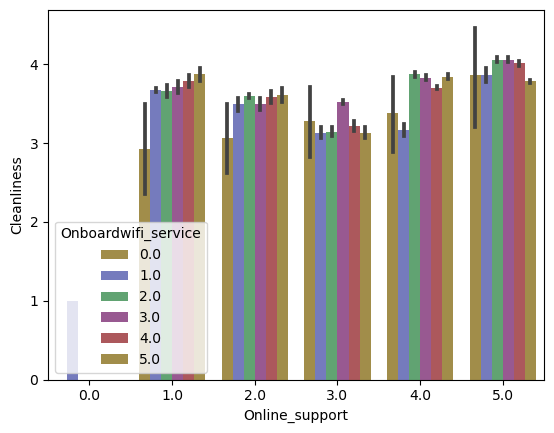

In [66]:
tech_cleanliness = transformed_df[['Online_support', 'Onboardwifi_service', 'Cleanliness']]
sns.barplot(data=tech_cleanliness, x='Online_support', y='Cleanliness', hue='Onboardwifi_service', palette=our_colors)
plt.show()

In [37]:
merged_df[merged_df['Cleanliness'].isna()][['Online_support', 'Onboardwifi_service', 'Cleanliness']]

,Online_support,Onboardwifi_service,Cleanliness
3210,excellent,excellent,NaN
29045,poor,poor,NaN
48087,poor,poor,NaN
65681,good,good,NaN
79256,need improvement,acceptable,NaN
88733,excellent,excellent,NaN


/var/folders/fn/f9_8r_cj7cb6ffsgnzdj0yw40000gn/T/ipykernel_46195/3609590232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_age_cleanliness['Age'] = pd.cut(merged_df['Age'], 5, labels = ['25', '35', '45', '60', '80'])


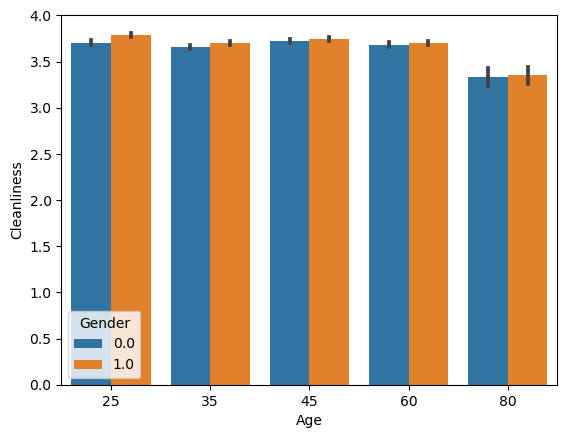

In [38]:
gender_age_cleanliness = transformed_df[['Age', 'Gender', 'Cleanliness']]
gender_age_cleanliness['Age'] = pd.cut(merged_df['Age'], 5, labels = ['25', '35', '45', '60', '80'])
sns.barplot(data=gender_age_cleanliness, x='Age', y='Cleanliness', hue='Gender')
plt.show()

**Conclusion:** 
From exploring the dataset, it seems that:
 - Cleanliness rating is independent of Gender and Age.
 - Cleanliness depends more on tech services, like wifi and online support.
 - Similar reviews to the ones that need to be imputed are Acceptable/Good in a 1:1 ratio.
 - Based on the bar chart comparing Cleanliness values per wifi and online support rating, I'd suggest imputing 'good' for all but one missing value (the one is a combination of 'need improvement' for online support and 'acceptable' for wifi).

### Imputing Online boarding

In [39]:
merged_df[merged_df['Online_boarding'].isna()]

,ID,Overall_Experience,Seat_comfort,Seat_Class,Arrival_time_convenient,Catering,Platform_location,Onboardwifi_service,Onboard_entertainment,Online_support,...,Cleanliness,Online_boarding,Gender,CustomerType,Age,TypeTravel,Travel_Class,Travel_Distance,DepartureDelay_in_Mins,ArrivalDelay_in_Mins
3210,2103211,1,extremely poor,Green Car,poor,extremely poor,manageable,excellent,extremely poor,excellent,...,NaN,NaN,Male,Loyal Customer,24.0,Personal Travel,Eco,1473,11.0,1.0
29045,2129046,1,extremely poor,Green Car,poor,extremely poor,manageable,poor,extremely poor,poor,...,NaN,NaN,Male,Loyal Customer,37.0,Personal Travel,Eco,1887,0.0,0.0
48087,2148088,1,extremely poor,Green Car,NaN,extremely poor,manageable,poor,extremely poor,poor,...,NaN,NaN,Male,Loyal Customer,42.0,Personal Travel,Eco,2311,0.0,0.0
65681,2165682,1,extremely poor,Green Car,poor,extremely poor,manageable,good,extremely poor,good,...,NaN,NaN,Male,Loyal Customer,34.0,Personal Travel,Eco,1816,0.0,0.0
79256,2179257,1,extremely poor,Ordinary,NaN,extremely poor,manageable,acceptable,extremely poor,need improvement,...,NaN,NaN,Male,Loyal Customer,24.0,Personal Travel,Eco,1826,0.0,0.0
88733,2188734,1,extremely poor,Green Car,poor,extremely poor,manageable,excellent,extremely poor,excellent,...,NaN,NaN,Female,Loyal Customer,29.0,Personal Travel,Eco,1918,16.0,5.0


In [40]:
similar_boarding = merged_df.query("Overall_Experience == 1 & Seat_comfort == 'extremely poor' & Seat_Class == 'Green Car' & Arrival_time_convenient == 'poor' & Catering == 'extremely poor' & Platform_location == 'manageable' & Onboard_entertainment == 'extremely poor' & TypeTravel == 'Personal Travel' & Travel_Class == 'Eco'")

In [41]:
similar_boarding['Online_boarding'].value_counts()

need improvement    4
acceptable          3
good                2
Name: Online_boarding, dtype: int64

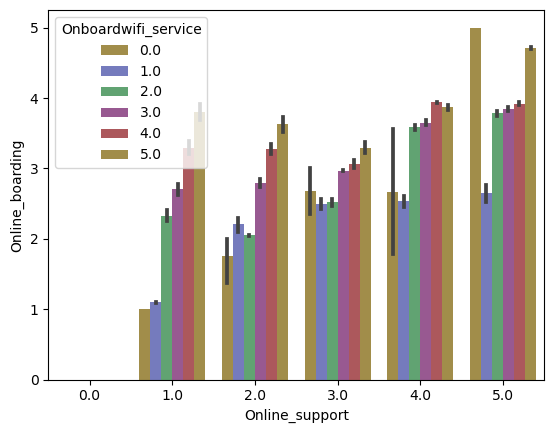

In [69]:
tech_boarding = transformed_df[['Online_support', 'Onboardwifi_service', 'Online_boarding']]
sns.barplot(data=tech_boarding, x='Online_support', y='Online_boarding', hue='Onboardwifi_service', palette=our_colors)
plt.show()

In [43]:
merged_df[merged_df['Online_boarding'].isna()][['Online_support', 'Onboardwifi_service', 'Online_boarding']]

,Online_support,Onboardwifi_service,Online_boarding
3210,excellent,excellent,NaN
29045,poor,poor,NaN
48087,poor,poor,NaN
65681,good,good,NaN
79256,need improvement,acceptable,NaN
88733,excellent,excellent,NaN


/var/folders/fn/f9_8r_cj7cb6ffsgnzdj0yw40000gn/T/ipykernel_46195/3976627564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_age_boarding['Age'] = pd.cut(merged_df['Age'], 5, labels = ['25', '35', '45', '60', '80'])


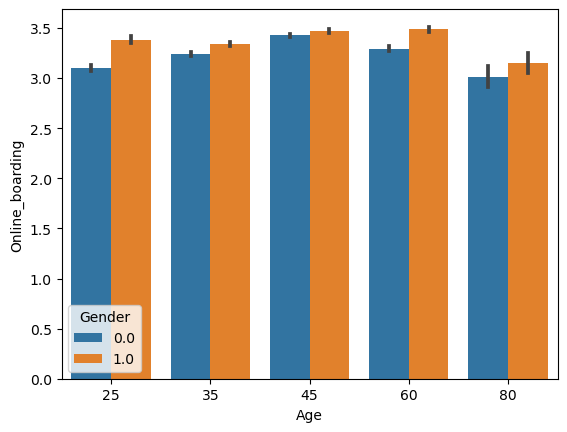

In [44]:
gender_age_boarding = transformed_df[['Age', 'Gender', 'Online_boarding']]
gender_age_boarding['Age'] = pd.cut(merged_df['Age'], 5, labels = ['25', '35', '45', '60', '80'])
sns.barplot(data=gender_age_boarding, x='Age', y='Online_boarding', hue='Gender')
plt.show()

**Conclusions**:
 - Online boarding depends highly on other tech services.
 - Doesn't depend that much on age or gender.
 - I'd suggest an imputation based on the bar chart of other tech services: 'excellent' for both excellent rows, 'poor' for both poor rows, 'good' for the good row and 'acceptable' for the remaining row.

### Imputing Onboard entertainment

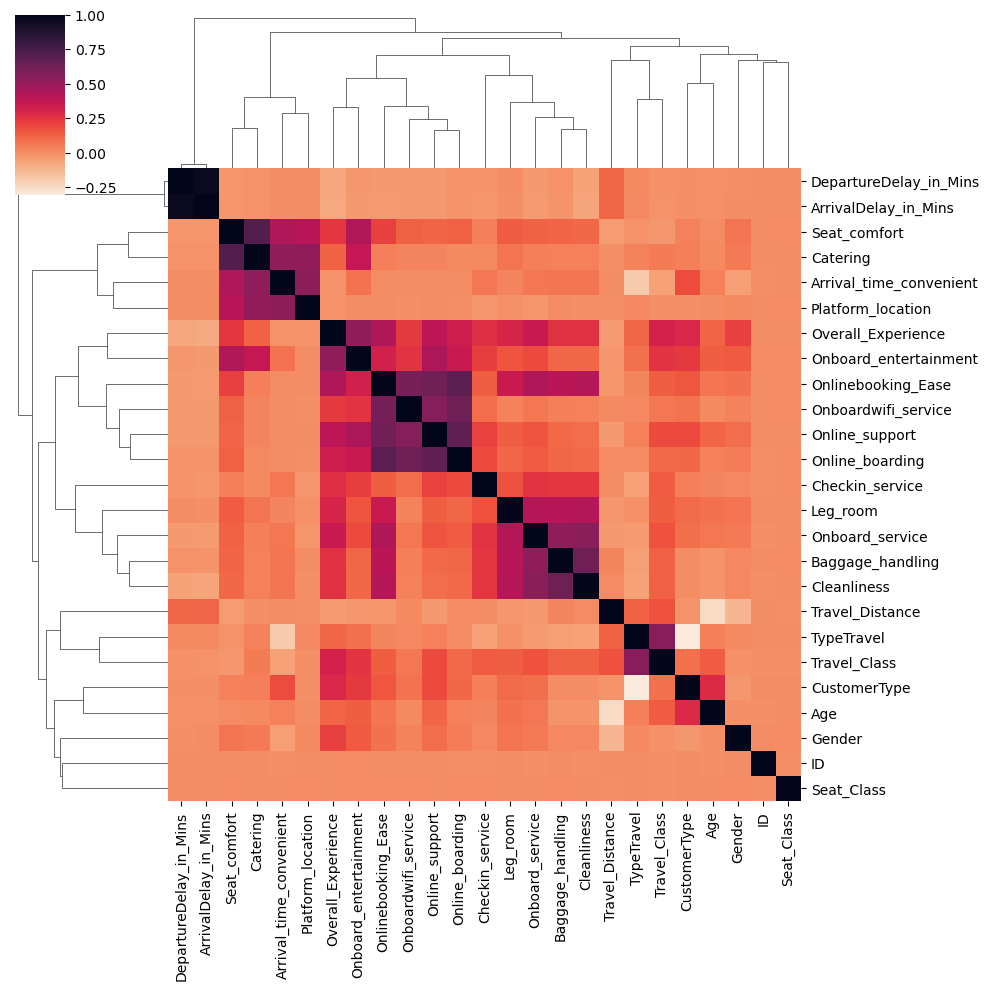

In [45]:
sns.clustermap(transformed_df.corr(), cmap="rocket_r")
plt.show()

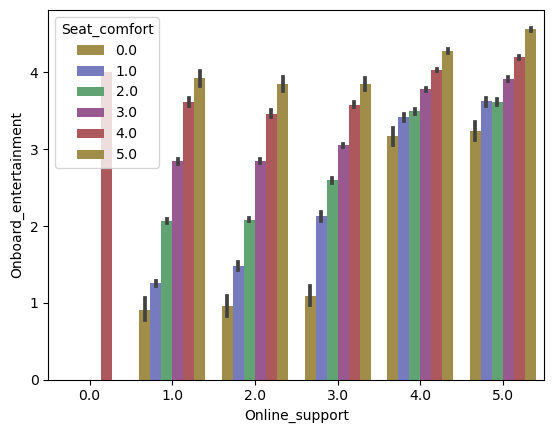

In [67]:
sns.barplot(data=transformed_df[['Online_support', 'Seat_comfort', 'Onboard_entertainment']], x='Online_support', y='Onboard_entertainment', hue='Seat_comfort', palette=our_colors)
plt.show()

In [47]:
fun_df = merged_df[['Overall_Experience', 'Online_support', 'Seat_comfort']].dropna()
fun_df['Onboard_entertainment'] = merged_df['Onboard_entertainment']

fun_imputed = impute_missing_ordinal_records(fun_df, list(fun_df.columns), n_classes=5)
fun_imputed

,Overall_Experience,Online_support,Seat_comfort,Onboard_entertainment
0,0,acceptable,need improvement,need improvement
1,0,good,poor,poor
2,1,excellent,need improvement,good
3,0,acceptable,acceptable,need improvement
4,1,excellent,acceptable,good
...,...,...,...,...
94222,0,poor,poor,poor
94223,1,excellent,good,excellent
94224,1,good,need improvement,excellent
94225,0,good,need improvement,need improvement


**Conclusions**:
 - Onboard entertainment is correlated with Overall experience, Online Support and Seat Comfort
 - Imputation can use all three parameters to fill in the missing values
 - An imputer of categorical ordinal data was created

### Imputing Platform location

In [48]:
merged_df['Platform_location'].value_counts()

manageable           24173
Convinient           21912
need improvement     17832
Inconvinient         16449
very convinient      13981
very inconvinient        2
Name: Platform_location, dtype: int64

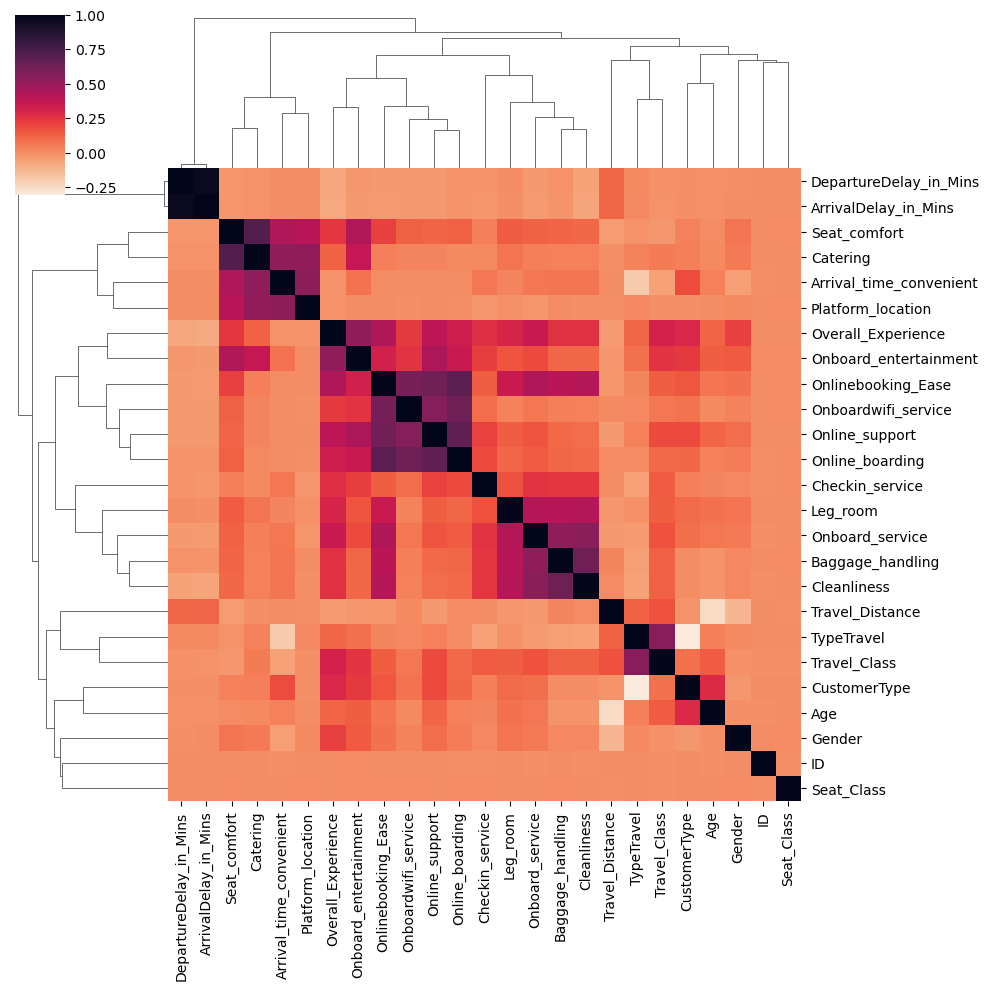

In [49]:
sns.clustermap(transformed_df.corr(), cmap="rocket_r")
plt.show()

**Heatmap** for `transformed_df`.

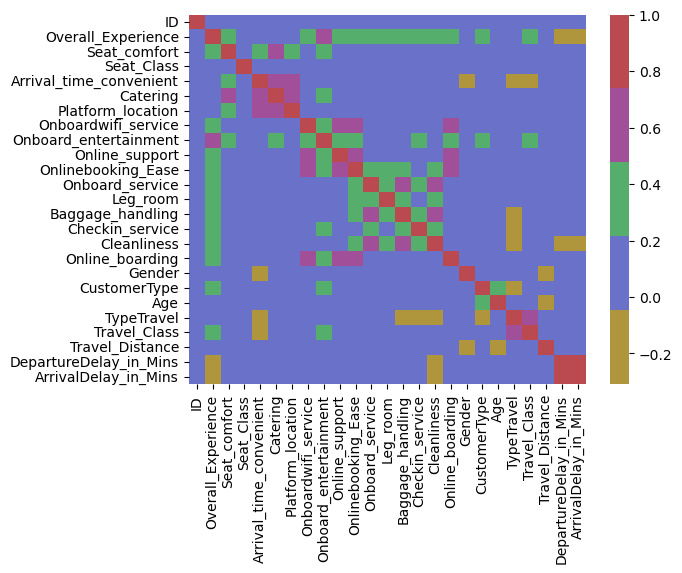

In [71]:
sns.heatmap(transformed_df.corr(), cmap=CMAP1)
plt.show()

Analyzing the heatmap we can conclude:
  - Strong correlation between `Overall_Experience` and `Onboard_entertainment`, `Onlinebooking_Ease`, `Onboard_service`, `Online_support`.
    - I want to analyze this further.

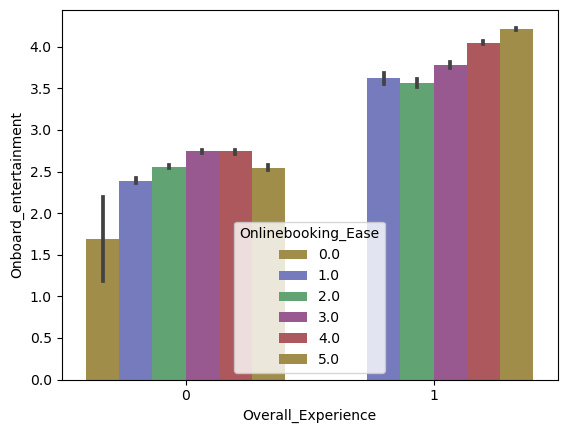

In [72]:
sns.barplot(data=transformed_df, x='Overall_Experience', y='Onboard_entertainment', hue='Onlinebooking_Ease', palette=our_colors)
plt.show()

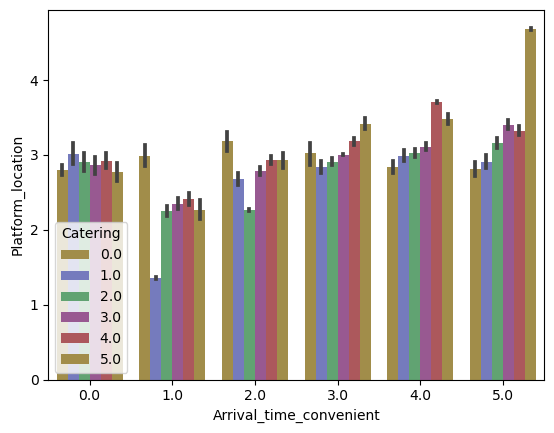

In [73]:
sns.barplot(data=transformed_df, x='Arrival_time_convenient', y='Platform_location', hue='Catering', palette=our_colors)
plt.show()

In [51]:
platform_df = merged_df[['Arrival_time_convenient', 'Catering']].dropna()
platform_df['Platform_location'] = merged_df['Platform_location']

platform_imputed = impute_missing_ordinal_records(platform_df, list(platform_df.columns), n_classes=5)
platform_imputed

,Arrival_time_convenient,Catering,Platform_location
0,excellent,excellent,very convinient
1,excellent,poor,need improvement
2,need improvement,need improvement,need improvement
3,acceptable,acceptable,manageable
4,need improvement,acceptable,need improvement
...,...,...,...
76723,good,good,Inconvinient
76724,good,good,Convinient
76725,good,good,Convinient
76726,need improvement,need improvement,need improvement


**Conclusions:**
 - Platform location has new set of categorie: 'very convinient', 'Convinient', 'manageable', 'need improvement', 'Inconvinient', 'very inconvinient'
 - Platform location is correlated with Arrival time convenience and Catering
 - Imputer was used to impute missing data